<a href="https://colab.research.google.com/github/clohaa/242project/blob/main/3.2%20Modelling_Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
file_path1 = 'drive/MyDrive/242 Project/Clean dataset/cluster0.csv'
with open(file_path1, 'r') as f1:
  df = pd.read_csv(f1)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

df.head()

,location,continent,date,new_deaths,new_cases,reproduction_rate,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand
0,India,Asia,2021-03-01,91.0,12286,1.14,0.19,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53
1,India,Asia,2021-03-02,98.0,14989,1.15,0.19,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53
2,India,Asia,2021-03-03,89.0,17407,1.16,0.21,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53
3,India,Asia,2021-03-04,113.0,16838,1.17,0.23,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53
4,India,Asia,2021-03-05,108.0,18284,1.18,0.25,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53


In [ ]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [ ]:
df.head()

,location,continent,date,new_deaths,new_cases,reproduction_rate,people_fully_vaccinated_per_hundred,stringency_index,population,population_density,aged_65_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand
0,India,Asia,2021-03-01,91.0,12286,1.14,0.19,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53
1,India,Asia,2021-03-02,98.0,14989,1.15,0.19,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53
2,India,Asia,2021-03-03,89.0,17407,1.16,0.21,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53
3,India,Asia,2021-03-04,113.0,16838,1.17,0.23,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53
4,India,Asia,2021-03-05,108.0,18284,1.18,0.25,63.43,1393409033,450.419,5.989,6426.674,21.2,282.28,10.39,1.9,20.6,0.53


Feature Engineering

In [ ]:
def create_date_features(df):
    # Since we have converted 'date' column into 'Date Format' we are allowed to use the methods that we see below(like : date.dt.month,day,year etc.) 
    df['month'] = df.date.dt.month # Which month of the corresponding year
    df['day_of_month'] = df.date.dt.day # Which day of the corresponding month
    df['day_of_year'] = df.date.dt.dayofyear # Which day of the corresponding year
    df['week_of_year'] = df.date.dt.weekofyear # Which week of the corresponding year
    df['day_of_week'] = df.date.dt.dayofweek # Which day of the corresponding week of the each month
    df["is_wknd"] = df.date.dt.weekday // 4 # df.date.dt.weekday => Starts from '0' means '0' = 'Monday'. So, '// 4' will give '1' when day number equals
    # to '5'(which corresponds 'Saturday') and '6'(which corresponds 'Sunday') and '0' for rest of them. Consequently this column will represent whether 
    # the day is weekend or not
    df['is_month_start'] = df.date.dt.is_month_start.astype(int) # Is it starting of the corresponding month
    df['is_month_end'] = df.date.dt.is_month_end.astype(int) # Is it ending of the corresponding month
    return df

In [ ]:
df = create_date_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   location                             2040 non-null   object        
 1   continent                            2040 non-null   object        
 2   date                                 2040 non-null   datetime64[ns]
 3   new_deaths                           2040 non-null   float64       
 4   new_cases                            2040 non-null   int64         
 5   reproduction_rate                    2040 non-null   float64       
 6   people_fully_vaccinated_per_hundred  2040 non-null   float64       
 7   stringency_index                     2040 non-null   float64       
 8   population                           2040 non-null   int64         
 9   population_density                   2040 non-null   float64       
 10  aged_65_olde

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [ ]:
# Create "Lag/Shifted Features" by using this function
# Since we will create more than 1 "Lag/Shifted Features" I created that function
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['new_deaths_lag_' + str(lag)] = dataframe.groupby(["location"])['new_deaths'].transform(lambda x: x.shift(lag)) 
    return dataframe

In [ ]:
lags_list = [7,8,9,10,11] 
df = lag_features(df, lags_list) 

In [ ]:
def lag_features_vaccination(dataframe, lags):
    for lag in lags:
        dataframe['people_fully_vaccinated_per_hundred_lag_' + str(lag)] = dataframe.groupby(["location"])['people_fully_vaccinated_per_hundred'].transform(lambda x: x.shift(lag)) 
    return dataframe

In [ ]:
lags_list = [7,8,9,10,11] 
df = lag_features_vaccination(df, lags_list) 

In [ ]:
def lag_features_cases(dataframe, lags):
    for lag in lags:
        dataframe['new_cases_lag_' + str(lag)] = dataframe.groupby(["location"])['new_cases'].transform(lambda x: x.shift(lag)) 
    return dataframe

In [ ]:
lags_list = [7,8,9,10,11]
df = lag_features_cases(df, lags_list) 

In [ ]:
df.dropna(axis = 0, inplace = True)

In [ ]:
rf_train = df[df['date'] < '2021-09-01']
rf_test = df[df['date'] >= '2021-09-01']

len(rf_train), len(rf_test)

(1384, 568)

Random Forest with Cross Validation

In [ ]:
y_train_rf = rf_train['new_cases']
X_train_rf = rf_train.drop(['date','new_cases','new_deaths','people_fully_vaccinated_per_hundred'], axis=1)
X_train_rf = pd.get_dummies(X_train_rf, dtype=int)
X_train_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384 entries, 11 to 1968
Data columns (total 45 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   reproduction_rate                           1384 non-null   float64
 1   stringency_index                            1384 non-null   float64
 2   population                                  1384 non-null   int64  
 3   population_density                          1384 non-null   float64
 4   aged_65_older                               1384 non-null   float64
 5   gdp_per_capita                              1384 non-null   float64
 6   extreme_poverty                             1384 non-null   float64
 7   cardiovasc_death_rate                       1384 non-null   float64
 8   diabetes_prevalence                         1384 non-null   float64
 9   female_smokers                              1384 non-null   float64
 10  male_smoker

In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


grid_values = {'max_features': np.linspace(1,45,10, dtype='int32'),
              'min_samples_leaf': [5],
              'n_estimators': [500],
              'random_state': [88]} 

tic = time.time()

rf = RandomForestRegressor() 
rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring='r2', cv=10,verbose = 1)
rf_cv.fit(X_train_rf, y_train_rf)

toc = time.time()
print('time:', round(toc-tic, 2),'s')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
time: 357.56 s


(-1.0, 1.0)

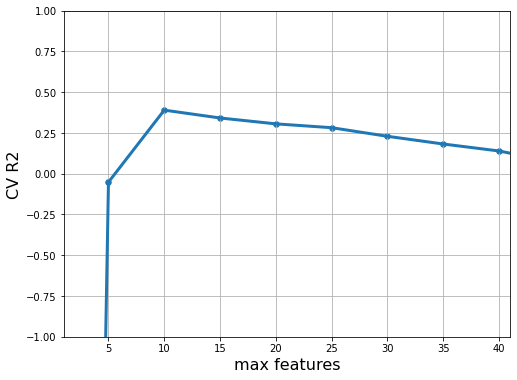

In [ ]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 41])
plt.ylim([-1, 1])

In [ ]:
print(rf_cv.best_params_)

{'max_features': 10, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


In [ ]:
feature = pd.DataFrame({'Feature' : X_train_rf.columns, 
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)
feature_sorted = feature.sort_values(by=['Importance score'],ascending=True)
feature_sorted

,Feature,Importance score
42,location_Zambia,0.0
18,is_month_start,0.0
17,is_wknd,0.0
16,day_of_week,0.0
40,location_Senegal,0.0
11,hospital_beds_per_thousand,0.0
19,is_month_end,0.0
9,female_smokers,0.0
10,male_smokers,0.0
7,cardiovasc_death_rate,0.0


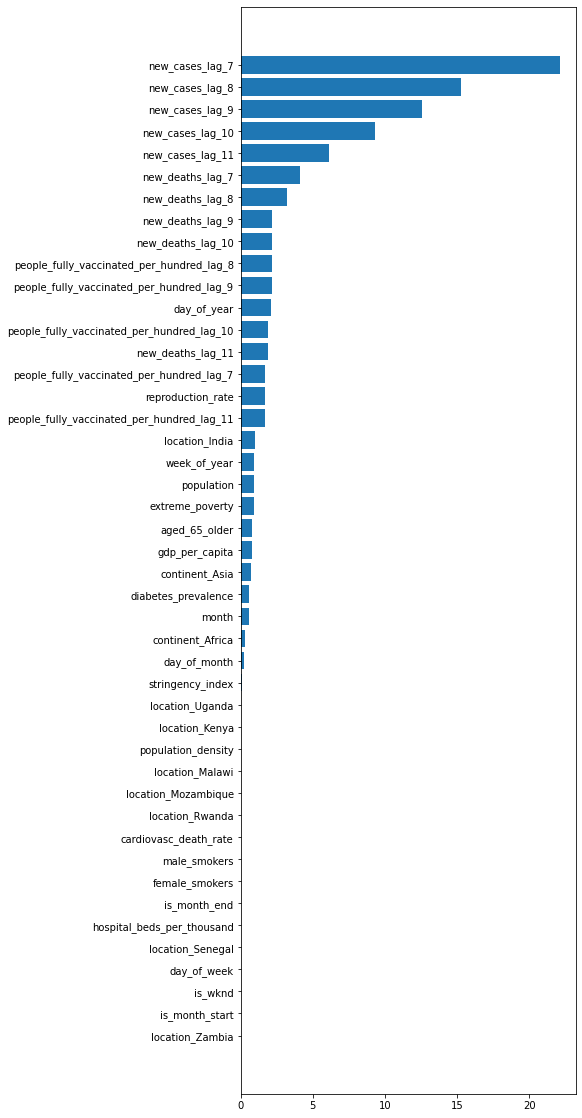

In [ ]:
plt.figure(figsize=(6,20))
plt.barh(feature_sorted['Feature'], feature_sorted['Importance score'])
plt.show()

In [ ]:
y_pred_rf = rf_cv.predict(X_train_rf)

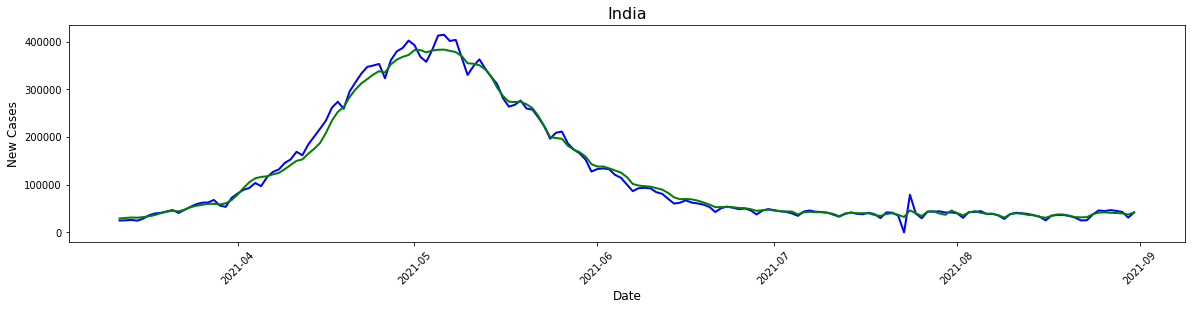

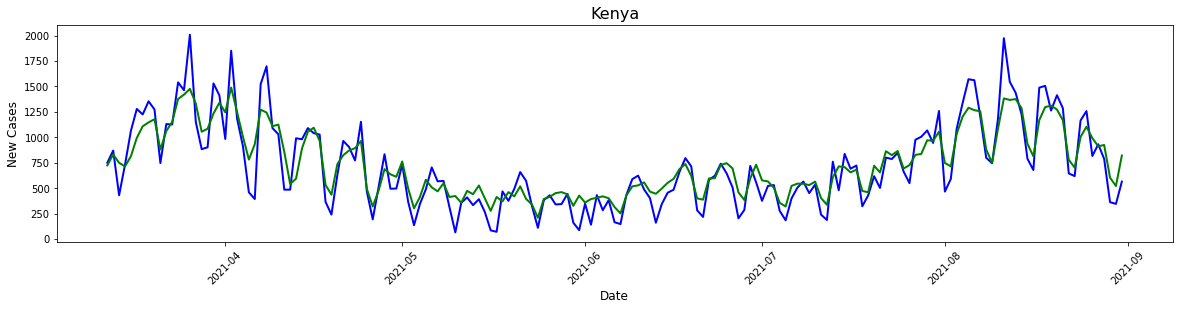

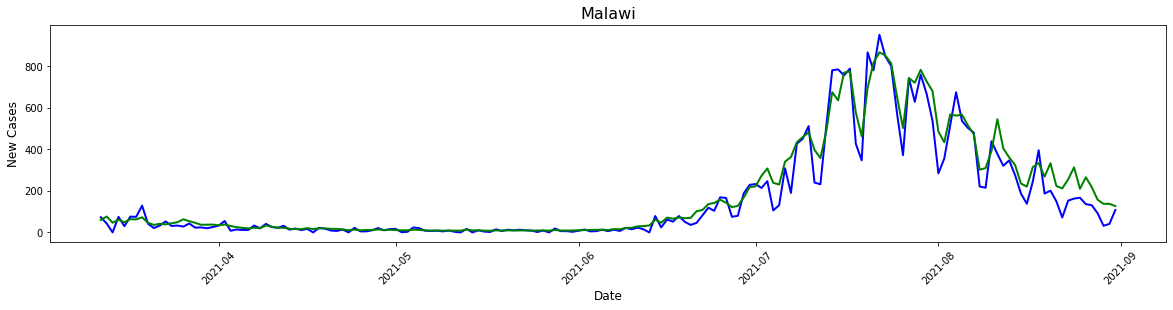

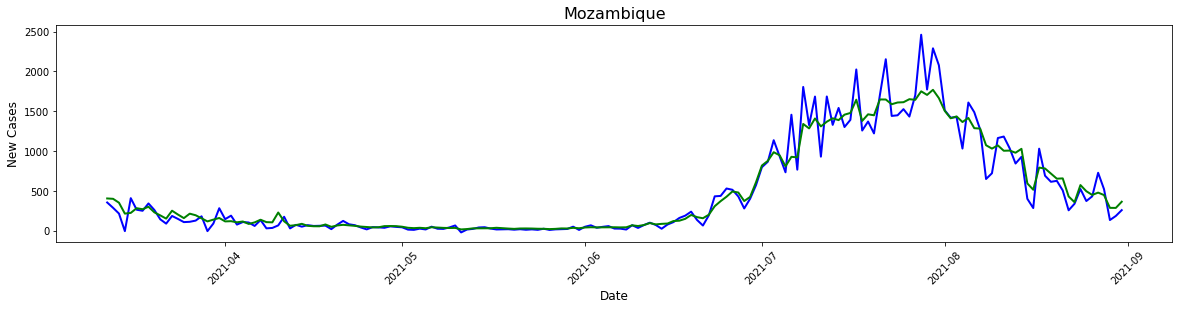

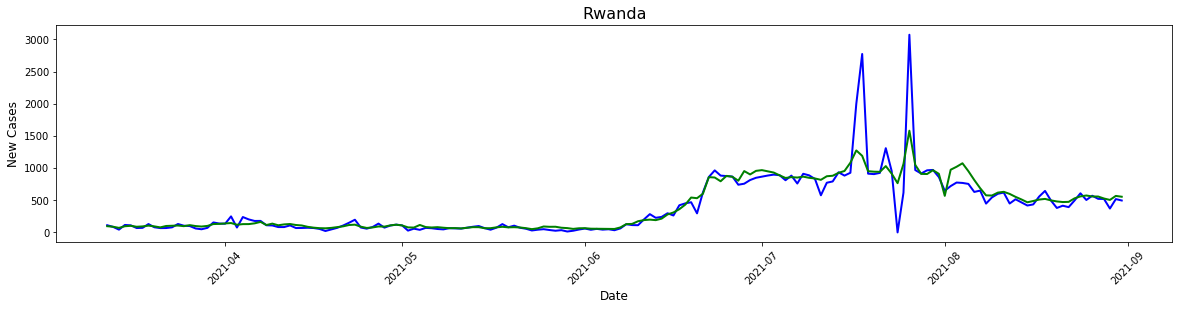

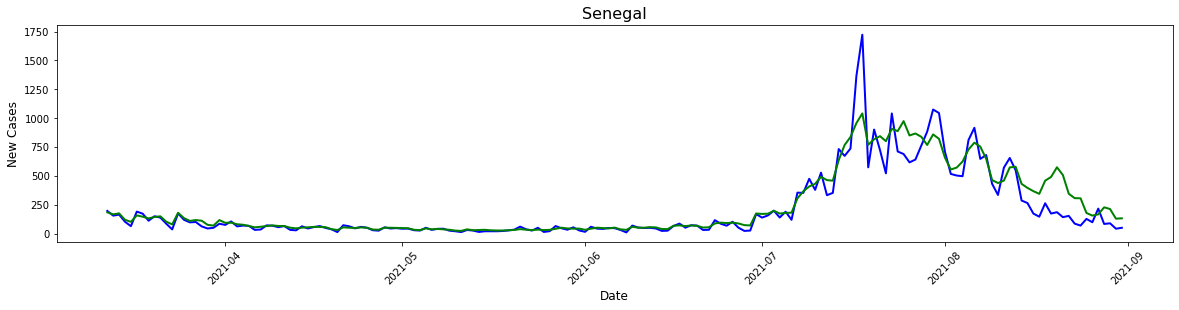

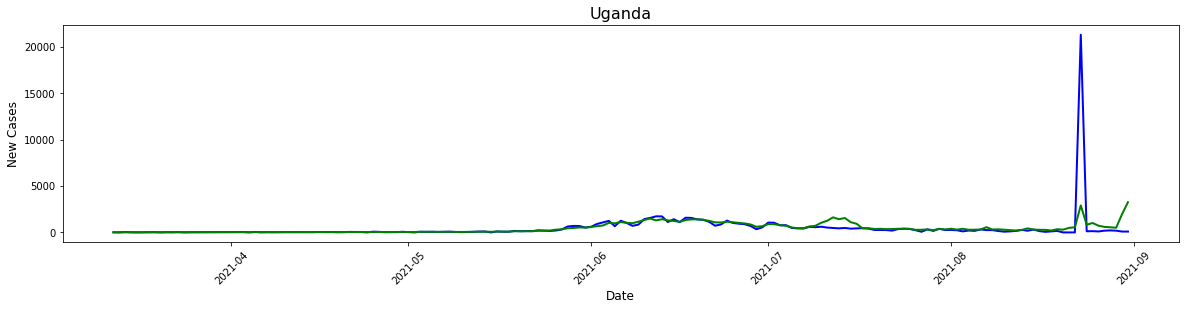

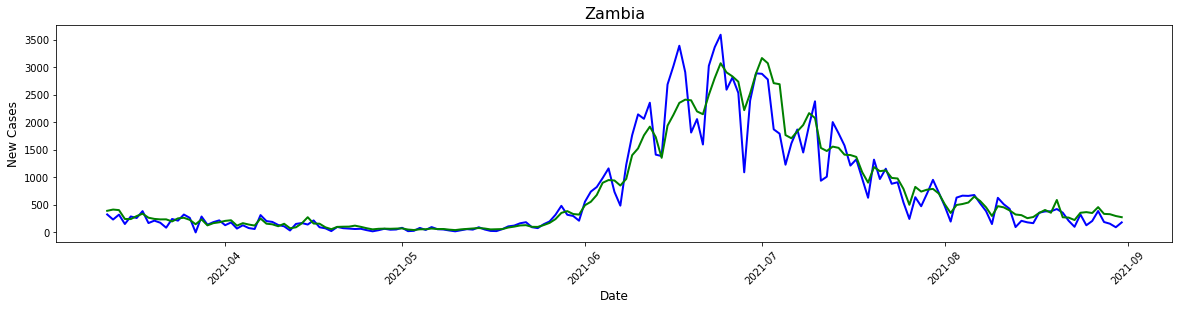

In [ ]:
cluster_0_countries = ['India', 'Kenya', 'Malawi', 'Mozambique', 'Rwanda', 'Senegal', 'Uganda', 'Zambia']
#count=[0,181,362,543,724,905,1086,1267,1448]
#count=[0,179,358,537,716,895,1074,1253,1432]
count=[0,173,346,519,692,865,1038,1211,1384]

for i in range(len(cluster_0_countries)):
  x = rf_train.loc[rf_train['location'] == cluster_0_countries[i]]['date'].to_numpy()
  y = y_train_rf[count[i]:count[i+1]].to_numpy()
  plt.figure(figsize=(20, 4))
  plt.plot(x, y, linewidth=2, color='blue')
  plt.plot(x,y_pred_rf[count[i]:count[i+1]],linewidth =2, color = 'green')
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('New Cases', fontsize=12)
  plt.xticks(rotation = 45)

  plt.title(cluster_0_countries[i],fontsize=16)
  plt.show()

In [ ]:
#evaluation on test set
y_test_rf = rf_test['new_cases']
X_test_rf = rf_test.drop(['date','new_deaths','new_cases','people_fully_vaccinated_per_hundred'], axis=1)
X_test_rf = pd.get_dummies(X_test_rf, dtype=int)
X_test_rf.info()
y_test_rf_pred = rf_cv.predict(X_test_rf)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568 entries, 184 to 2039
Data columns (total 45 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   reproduction_rate                           568 non-null    float64
 1   stringency_index                            568 non-null    float64
 2   population                                  568 non-null    int64  
 3   population_density                          568 non-null    float64
 4   aged_65_older                               568 non-null    float64
 5   gdp_per_capita                              568 non-null    float64
 6   extreme_poverty                             568 non-null    float64
 7   cardiovasc_death_rate                       568 non-null    float64
 8   diabetes_prevalence                         568 non-null    float64
 9   female_smokers                              568 non-null    float64
 10  male_smoker

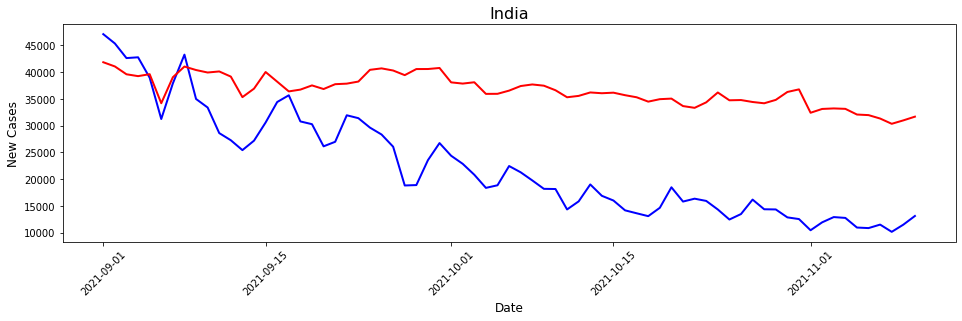

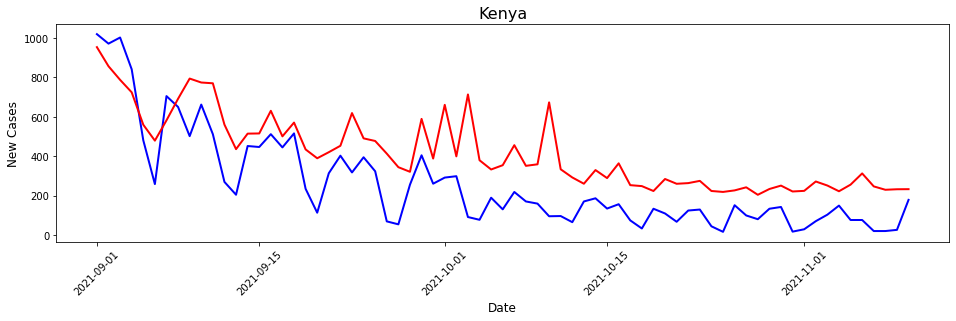

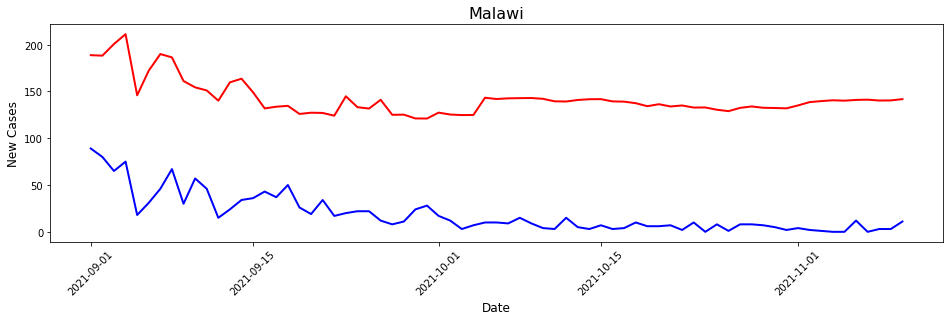

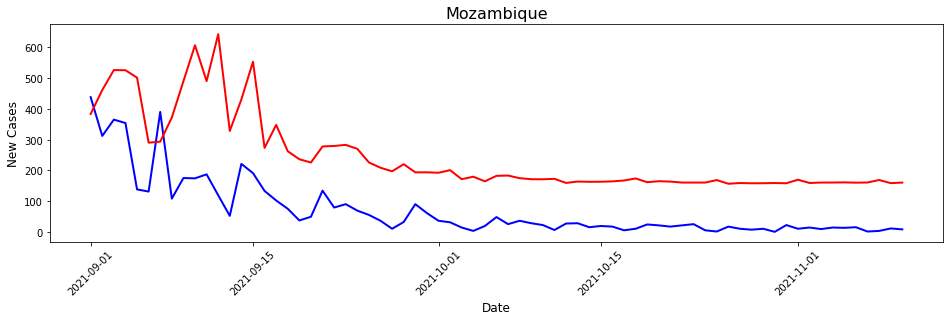

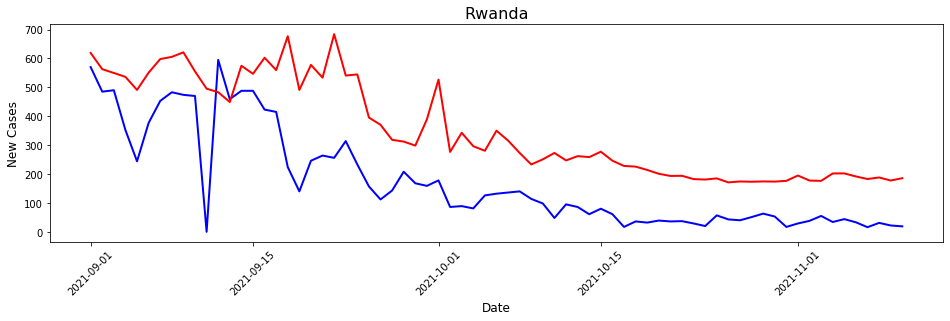

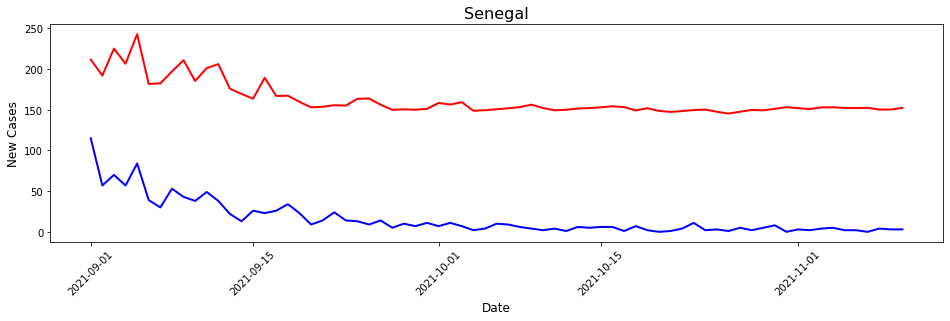

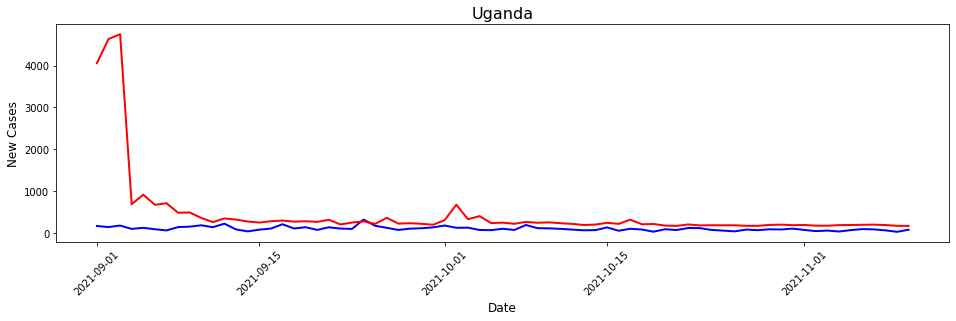

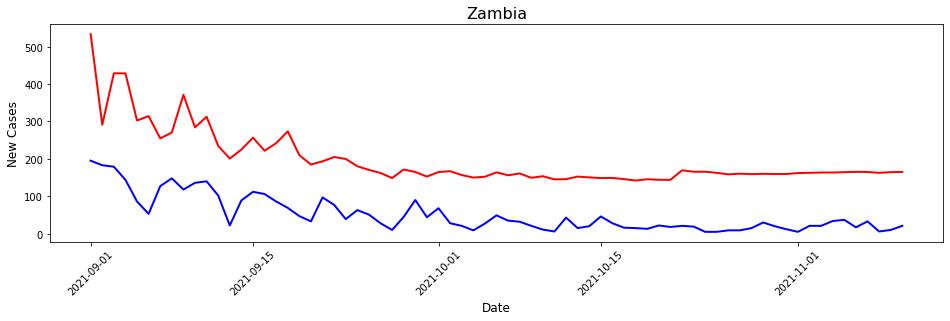

In [ ]:
count=[0,71,142,213,284,355,426,497,568]
for i in range(len(cluster_0_countries)):
  x = rf_test['date'][count[i]:count[i+1]].to_numpy()
  y = y_test_rf[count[i]:count[i+1]].to_numpy()
  plt.figure(figsize=(16, 4))
  plt.plot(x, y, linewidth=2, color='blue')
  plt.plot(x,y_test_rf_pred[count[i]:count[i+1]],linewidth =2, color = 'red')
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('New Cases', fontsize=12)
  plt.xticks(rotation = 45)
  plt.title(cluster_0_countries[i],fontsize=16)
  plt.show()

In [ ]:
def OSR2(y_train, y_test, y_pred):
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)             
    return (1 - SSE/SST)

def MAE(y_test, y_pred):
    return (np.mean(abs(y_test - y_pred)))

def RMSE(y_test, y_pred):
    return np.sqrt(np.mean((y_test - y_pred)**2))

def print_metrics(model, X_train, y_train, X_test, y_test):
    y_pred_train = pd.Series(model.predict(X_train)).reset_index(drop=True)
    y_pred_test = pd.Series(model.predict(X_test)).reset_index(drop=True)
    y_train = y_train.copy().reset_index(drop=True)
    y_test = y_test.copy().reset_index(drop=True)    
    
    print('Training R2', OSR2(y_train, y_train, y_pred_train))
    print('Training MAE', MAE(y_train, y_pred_train))
    print('Training RMSE', RMSE(y_train, y_pred_train))

    print('Out-of-sample R2', OSR2(y_train, y_test, y_pred_test))
    print('Out-of-sample MAE', MAE(y_test, y_pred_test))
    print('Out-of-sample RMSE', RMSE(y_test, y_pred_test))

In [ ]:
print_metrics(rf_cv, X_train_rf, y_train_rf, X_test_rf, y_test_rf)

Training R2 0.9959227069830598
Training MAE 969.4851854319536
Training RMSE 3743.630514742136
Out-of-sample R2 0.8607784650931134
Out-of-sample MAE 2003.6040137992761
Out-of-sample RMSE 5736.151447127806


Regularization (Ridge regression) - bias-variance tradeoff

In [ ]:
X_train_rr = X_train_rf
X_test_rr = X_test_rf

print(X_train_rr.shape, X_test_rr.shape)

(1384, 45) (568, 45)


In [ ]:
#determine alpha_max

from sklearn.linear_model import Ridge

alpha_max = 10**5
rr = Ridge(alpha=alpha_max, random_state=88)
rr.fit(X_train_rr, y_train_rf)

Ridge(alpha=100000, random_state=88)

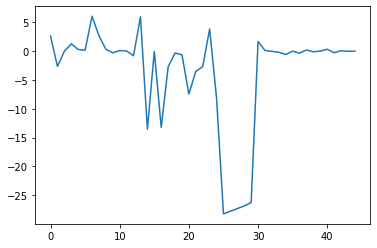

28.27679631415423


In [ ]:
plt.plot(rr.coef_)
plt.show()
print(max(abs(rr.coef_)))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
alpha_grid = np.logspace(-1, 5, num=50, base=10)
coefs = []

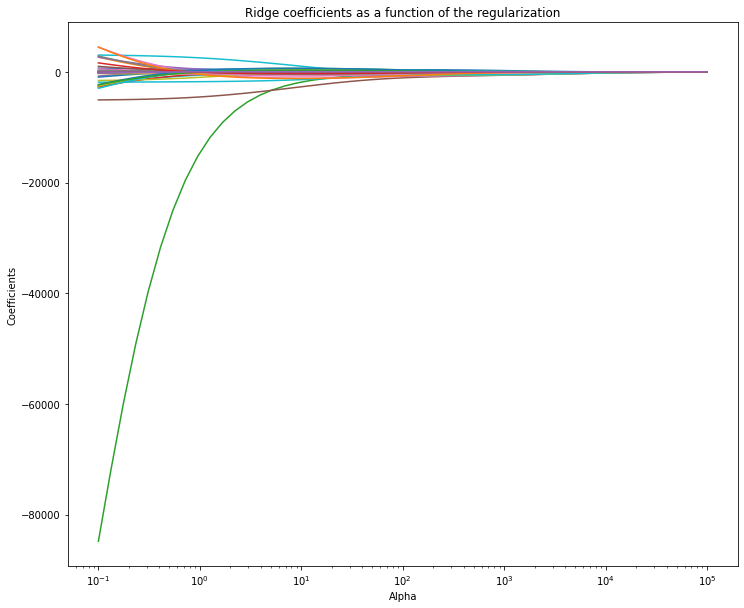

In [ ]:
for a in alpha_grid:
    rr = Ridge(alpha=a, fit_intercept=False, random_state=88)
    rr.fit(X_train_rr, y_train_rf)
    coefs.append(rr.coef_)

plt.figure(figsize=(12, 10))
ax = plt.gca()
ax.plot(alpha_grid, coefs)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.show()

In [ ]:
# Ridge Hyper-parameter Tuning
from sklearn.model_selection import GridSearchCV

alpha_grid = {'alpha': np.logspace(-1, 5, num=50, base=10)}

rr = Ridge(random_state=88)
rr_cv = GridSearchCV(rr, alpha_grid, scoring='neg_mean_squared_error', cv=10)
rr_cv.fit(X_train_rr, y_train_rf)

GridSearchCV(cv=10, estimator=Ridge(random_state=88),
             param_grid={'alpha': array([1.00000000e-01, 1.32571137e-01, 1.75751062e-01, 2.32995181e-01,
       3.08884360e-01, 4.09491506e-01, 5.42867544e-01, 7.19685673e-01,
       9.54095476e-01, 1.26485522e+00, 1.67683294e+00, 2.22299648e+00,
       2.94705170e+00, 3.90693994e+00, 5.17947468e+00, 6.86648845e+00,
       9.10298178e+00, 1.20679264e+01, 1...
       2.68269580e+02, 3.55648031e+02, 4.71486636e+02, 6.25055193e+02,
       8.28642773e+02, 1.09854114e+03, 1.45634848e+03, 1.93069773e+03,
       2.55954792e+03, 3.39322177e+03, 4.49843267e+03, 5.96362332e+03,
       7.90604321e+03, 1.04811313e+04, 1.38949549e+04, 1.84206997e+04,
       2.44205309e+04, 3.23745754e+04, 4.29193426e+04, 5.68986603e+04,
       7.54312006e+04, 1.00000000e+05])},
             scoring='neg_mean_squared_error')

In [ ]:
def one_standard_error_rule(model, results, param_grid, n_splits, neg_mean_squared_error=True):
    
    assert neg_mean_squared_error == True # function is defined specifically for neg_mean_squared_error
    
    #find model with minimum error, then select the simplest model
    #whose mean falls within 1 standard deviation of the minimum
    
    range_x = param_grid # results['param_'+list(param_grid.keys())[0]].data
    std_vs_x  = pd.Series(results['std_test_score'], index = range_x)
    sem_vs_x  = std_vs_x/np.sqrt(n_splits)
    
    mean_vs_x = pd.Series(results['mean_test_score'], index = range_x)        
    mean_vs_x = mean_vs_x*(-1)
    
    x_min = mean_vs_x.idxmin()
    sem = sem_vs_x[x_min]
    

    if (model=='pcr'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.min()
    elif (model=='ridge') | (model=='lasso'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.max()
        
    #x_1se_idx = int(np.argwhere(range_x == x_1se)[0])
    
    return x_min, x_1se

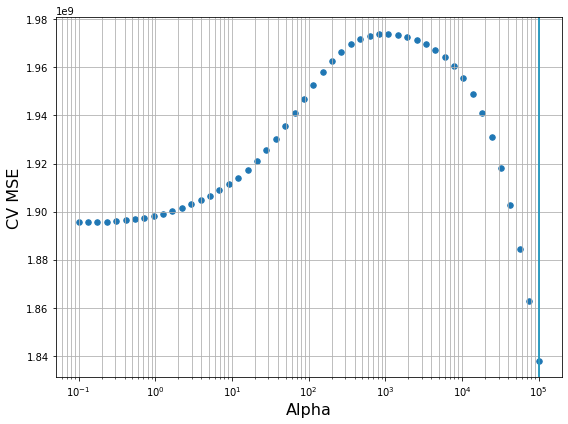

In [ ]:
range_alpha = rr_cv.cv_results_['param_alpha'].data
MSE_scores = rr_cv.cv_results_['mean_test_score']*(-1)
x_min, x_1se = one_standard_error_rule(model='ridge',
                                       results=rr_cv.cv_results_,
                                       param_grid=range_alpha,
                                       n_splits=10,
                                       neg_mean_squared_error=True)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('CV MSE', fontsize=16)
plt.scatter(range_alpha, MSE_scores, s=30)
plt.axvline(x=x_min, color='m')
plt.axvline(x=x_1se, color='c')
plt.grid(True, which='both')

plt.tight_layout()

plt.show()

In [ ]:
rr_cv = GridSearchCV(rr, {'alpha': [x_1se]}, scoring='neg_mean_squared_error', cv=10)
rr_cv.fit(X_train_rr, y_train_rf)

print('Ridge Regression performance:')
print_metrics(rr_cv, X_train_rr, y_train_rf, X_test_rr, y_test_rf)
print('\n')
print('Random Forest performance:')
print_metrics(rf_cv, X_train_rf, y_train_rf, X_test_rf, y_test_rf)

Ridge Regression performance:
Training R2 0.9764304345751431
Training MAE 3079.957212565333
Training RMSE 9000.835082932565
Out-of-sample R2 0.8105002198352428
Out-of-sample MAE 3879.903369357587
Out-of-sample RMSE 6692.24382477396


Random Forest performance:
Training R2 0.9959227069830598
Training MAE 969.4851854319536
Training RMSE 3743.630514742136
Out-of-sample R2 0.8607784650931134
Out-of-sample MAE 2003.6040137992761
Out-of-sample RMSE 5736.151447127806


Ridge regression does not really improve OSR-squared, so we will keep the original random forest model